In [138]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
n_months = 34

c:\Users\Jesper\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [20]:
#import
train = pd.read_csv('data/sales_train.csv', encoding='utf8')
test = pd.read_csv('data/test.csv', encoding='utf8')
print(train)
print(test)

               date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...               ...  
293

In [21]:
#Preprocess
#rm outlier data
#neg price <- probs does 0 difference
#any other?
rm_inds = train.loc[train['item_price'] <= 0].index.to_numpy()
train.drop(index=rm_inds, axis=0,inplace=True)


In [22]:
#Make row pairs matching test data
#Drop cols
train.drop(['date','item_price'],axis=1,inplace=True)
print(train)

         date_block_num  shop_id  item_id  item_cnt_day
0                     0       59    22154           1.0
1                     0       25     2552           1.0
2                     0       25     2552          -1.0
3                     0       25     2554           1.0
4                     0       25     2555           1.0
...                 ...      ...      ...           ...
2935844              33       25     7409           1.0
2935845              33       25     7460           1.0
2935846              33       25     7459           1.0
2935847              33       25     7440           1.0
2935848              33       25     7460           1.0

[2935849 rows x 4 columns]


In [84]:
new_tr = pd.DataFrame(np.zeros((n_months,len(test))))
for i in range(len(test)):
    #i=6000
    blocked = train.loc[train['shop_id']==test['shop_id'].iloc[i]].loc[train['item_id']==test['item_id'].iloc[i]].groupby('date_block_num').sum()
    #print(blocked)
    #print(blocked.index.values)
    if not blocked.empty:
        for ind,j in enumerate(blocked.index.values):
            #print(blocked.iloc[j]['item_cnt_day'])
            new_tr.iloc[j][i] = blocked.iloc[ind]['item_cnt_day']
            
        #print(new_tr.iloc[i])
new_tr.to_csv('per_item_train.csv')

In [109]:
#https://www.kaggle.com/code/drscarlat/future-sales-forecasting-w-sarima-and-fb-prophet/notebook 
#https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/overview/evaluation

#Train set-up
preds = pd.DataFrame(np.zeros(len(test)))
preds.index.name = 'ID'
preds.columns = ['item_cnt_month']
tr = pd.DataFrame(columns=['ds','y'])
tr['ds']=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
#Predict for november:

for i in range(len(test)):
    if new_tr[i].sum() == 0:
        continue
    #i = 2   
    tr['y'] = new_tr[i]
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    m.fit(tr)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')  
    forecast = m.predict(future)
    pred_val = forecast['yhat'].iloc[34]
    if pred_val>20:
        pred_val = 20
    elif pred_val<0:
        pred_val = 0
    preds.iloc[i] = pred_val
    #print(preds)
preds.to_csv('pred_prophet.csv')

11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing
11:53:14 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:18 - cmdstanpy - INFO - Chain [1] start processing
11:53:18 - cmdstanpy - INFO - Chain [1] done processing
11:53:19 - cmdstanpy - INFO - Chain [1] start processing
11:53:19 - cmdstanpy - INFO - Chain [1] done processing
11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:20 - cmdstanpy - INFO - Chain [1] done processing
11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing
11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [130]:
#data processing
data = train.groupby(["date_block_num"])["item_cnt_day"].sum()
data.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
data=data.reset_index()
data.columns = ['ds','y']

#split data 80-20
split = int(0.8*len(data))+1
print(f'train months {split}')
train_data = data.iloc[:split]
test_data = data.iloc[split:]

train months 28


In [135]:
#fit and predict
m = Prophet(yearly_seasonality=True, weekly_seasonality=False) 
m.fit(train_data)
future_df = m.make_future_dataframe(periods = len(test_data), freq = 'MS')  
pred = m.predict(future_df)

21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done processing


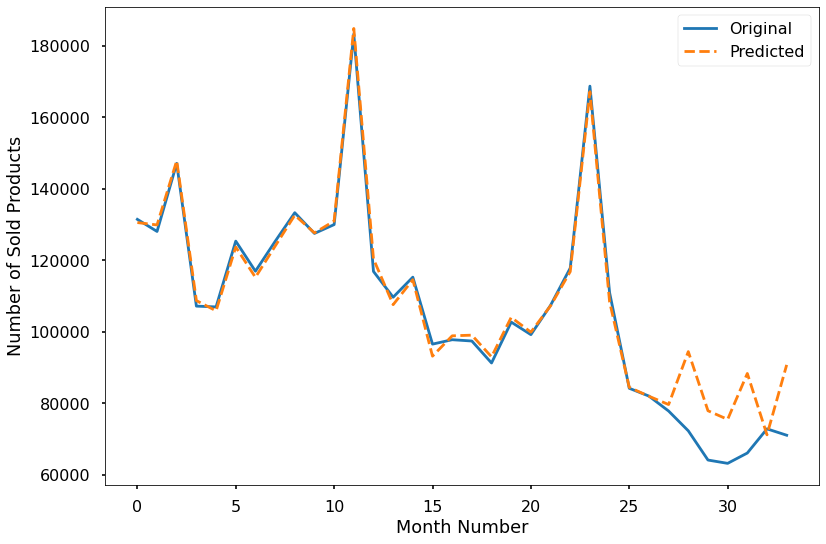

In [137]:
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(data['y'], label='Original')
plt.plot(pred['yhat'], ls='--', label="Predicted")
plt.legend(loc='best')
plt.xlabel('Month Number')
plt.ylabel('Number of Sold Products')
plt.show()

In [139]:
rmse = np.sqrt(mean_squared_error(test_data['y'],pred['yhat'][split:]))
print('RMSE: %.1f' % rmse)

Val RMSE: 16928.1
